# Feature Embedding Clustering and Interpretation

This notebook demonstrates how to:
1. Load a trained rade-features splat model
2. Extract feature embeddings from Gaussians
3. Cluster embeddings to discover discrete semantic categories
4. Decode CLIP embeddings to get interpretable semantic labels

Based on patterns from test_grouping.ipynb and create_mesh.ipynb

## Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import gc
import pickle
from pathlib import Path
from typing import List, Dict, Optional

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Clustering libraries
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Visualization libraries
import pyvista as pv
import open3d as o3d

# Collab-splats imports
from collab_splats.wrapper import Splatter, SplatterConfig
from collab_splats.utils.features import BaseFeatureExtractor
from collab_splats.utils.pointcloud import clean_pcd
from collab_splats.utils.visualization import (
    CAMERA_KWARGS,
    MESH_KWARGS,
    VIZ_KWARGS,
    visualize_splat,
)
from nerfstudio.utils.eval_utils import eval_setup

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Taichi] version 1.7.4, llvm 15.0.4, commit b4b956fd, linux, python 3.10.18


[I 10/11/25 21:21:46.851 45716] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


## Configuration: Set Path to Trained Model

Update these paths to point to your trained rade-features model

In [2]:
# Example configuration - update these paths for your model
SPLATS = {
    'birds': {
        'base_dir': '/workspace/fieldwork-data/birds/2024-02-06/',
        'environment': 'environment/C0043/rade-features',
        'load_config': "2025-07-25_040743/config.yml",
        'video_name': 'C0043.mp4',
    },
    'rats': {
        'base_dir': '/workspace/fieldwork-data/rats/2024-07-11/',
        'environment': 'environment/C0119/rade-features',
        'load_config': "2025-07-25_074037/config.yml",
        'video_name': 'C0119.MP4',
    }
}

# Select which dataset to use
species = 'rats'  # Change to 'rats' or add your own
base_dir = Path(SPLATS[species]['base_dir'])
load_config = base_dir / SPLATS[species]['environment'] / SPLATS[species]['load_config']

print(f"Loading model from: {load_config}")
print(f"Model exists: {load_config.exists()}")

Loading model from: /workspace/fieldwork-data/rats/2024-07-11/environment/C0119/rade-features/2025-07-25_074037/config.yml
Model exists: True


## Load Splatter

In [3]:
splatter_config = SplatterConfig(
    file_path= base_dir / "SplatsSD" / SPLATS[species]['video_name'],
    method="rade-features",
    frame_proportion=0.25,  # Use 25% of the frames within the video (or default to minimum 300 frames)
)

# Initialize the Splatter class
splatter = Splatter(splatter_config)

# Call these to populate the splatter with paths (probably a better way to do this --> maybe save out config)
splatter.preprocess()
splatter.extract_features()
splatter.mesh()

transforms.json already exists at /workspace/fieldwork-data/rats/2024-07-11/environment/C0119/preproc/transforms.json
To rerun preprocessing, set overwrite=True
Output already exists for rade-features
To rerun feature extraction, set overwrite=True

Available runs:
[0] 2025-07-25_074037


## Load Trained Splat Model

Load the trained rade-features model using nerfstudio's eval_setup

In [4]:
# Load the pipeline and model
config, pipeline, checkpoint_path, step = eval_setup(
    config_path=load_config,
    eval_num_rays_per_chunk=None,
    test_mode='inference'
)

# Get the model
model = pipeline.model
model.eval()

print(f"Model type: {type(model).__name__}")
print(f"Number of Gaussians: {model.means.shape[0]:,}")
print(f"Feature embedding dimension: {model.config.features_latent_dim}")
print(f"Main feature type: {model.main_features_name}")

Loading cached samclip features...

[21:22:29] use color only optimization with sigmoid activation                                         ]8;id=786405;file:///opt/conda/envs/nerfstudio/lib/python3.10/site-packages/nerfstudio/models/splatfacto.py\splatfacto.py]8;;\:]8;id=636784;file:///opt/conda/envs/nerfstudio/lib/python3.10/site-packages/nerfstudio/models/splatfacto.py#213\213]8;;\

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
/workspace/fieldwork-data/rats/2024-07-11/environment/C0119/rade-features/2025-07-25_074037/nerfstudio_models/step-00002
9999.ckpt

Model type: RadegsFeaturesModel
Number of Gaussians: 1,295,257
Feature embedding dimension: 13
Main feature type: samclip


## Extract Feature Embeddings from Gaussians

Extract the learned feature embeddings (distill_features) from each Gaussian

In [5]:
OPACITY_THRESHOLD = 0.1
USE_SPATIAL_FILTER = False
MAX_GAUSSIANS_FOR_CLUSTERING = 1000000

# Extract feature embeddings from Gaussians
with torch.no_grad():
    # Get the latent feature embeddings (distill_features)
    feature_embeddings = model.distill_features.clone().cpu().numpy()
    
    # Also get Gaussian positions for spatial context
    gaussian_positions = model.means.clone().cpu().numpy()
    
    # Get opacities to filter low-opacity Gaussians
    opacities = torch.sigmoid(model.opacities).clone().cpu().numpy()

print(f"Feature embeddings shape: {feature_embeddings.shape}")
print(f"Gaussian positions shape: {gaussian_positions.shape}")
print(f"Opacities shape: {opacities.shape}")

# ====== Apply Filtering Strategies ======

# Strategy 1: Filter by opacity
valid_mask = opacities.squeeze() > OPACITY_THRESHOLD
filtered_features = feature_embeddings[valid_mask]
filtered_positions = gaussian_positions[valid_mask]

print(f"\nAfter opacity filtering (> {OPACITY_THRESHOLD}):")
print(f"  Valid Gaussians: {filtered_features.shape[0]:,} ({100*valid_mask.mean():.1f}%)")

# Free up memory
del gaussian_positions, opacities, valid_mask, feature_embeddings
gc.collect()
torch.cuda.empty_cache()

Feature embeddings shape: (1295257, 13)
Gaussian positions shape: (1295257, 3)
Opacities shape: (1295257, 1)

After opacity filtering (> 0.1):
  Valid Gaussians: 1,081,016 (83.5%)


## Dimensionality Reduction and Visualization

Use t-SNE to visualize the high-dimensional embeddings (PCA removed for simplicity, k-means works directly on features)

In [6]:
# t-SNE for 2D visualization (on filtered features directly, no PCA)
print("Performing t-SNE on filtered features... (this may take a few minutes)")

# Subsample if too many points for t-SNE
max_samples_for_tsne = 10000
if len(filtered_features) > max_samples_for_tsne:
    sample_idx = np.random.choice(len(filtered_features), max_samples_for_tsne, replace=False)
    features_for_tsne = filtered_features[sample_idx]
    positions_for_tsne = filtered_positions[sample_idx]
else:
    features_for_tsne = filtered_features
    positions_for_tsne = filtered_positions
    sample_idx = np.arange(len(filtered_features))

tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
features_tsne = tsne.fit_transform(features_for_tsne)

print(f"t-SNE embedding shape: {features_tsne.shape}")

Performing t-SNE on filtered features... (this may take a few minutes)
t-SNE embedding shape: (10000, 2)


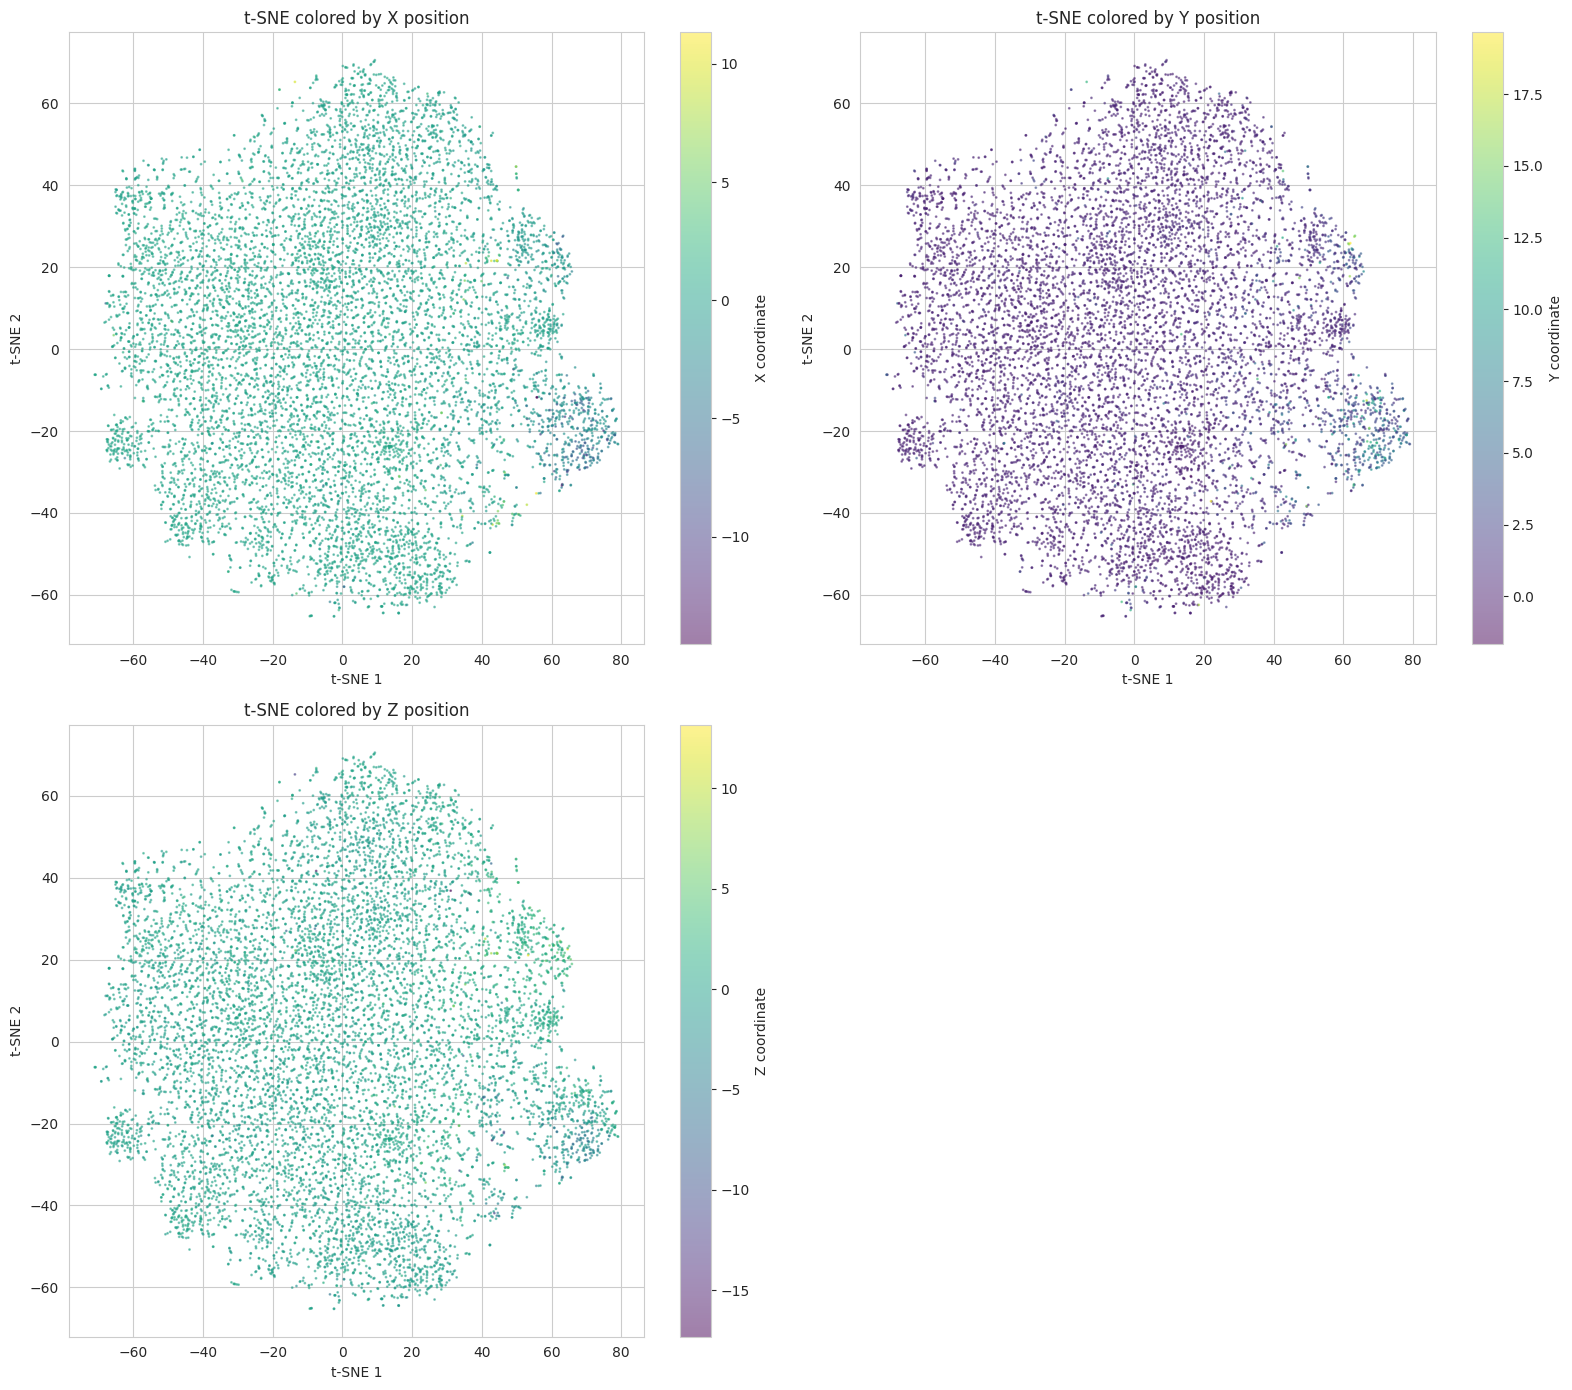

In [7]:
# Visualize t-SNE embedding colored by spatial position
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Color by X, Y, Z positions
for idx, (ax, coord, label) in enumerate(zip(
    axes.flatten()[:3], 
    [0, 1, 2], 
    ['X', 'Y', 'Z']
)):
    scatter = ax.scatter(
        features_tsne[:, 0], 
        features_tsne[:, 1], 
        c=positions_for_tsne[:, coord],
        cmap='viridis',
        s=1,
        alpha=0.5
    )
    ax.set_title(f't-SNE colored by {label} position')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    plt.colorbar(scatter, ax=ax, label=f'{label} coordinate')

# Remove the 4th subplot
axes.flatten()[3].remove()

plt.tight_layout()
plt.show()

## Clustering Analysis

Apply different clustering algorithms to discover semantic categories

### K-Means Clustering

Start with K-means to find a fixed number of clusters

Finding optimal number of clusters using elbow method...
Using: MiniBatchKMeans


  0%|          | 0/48 [00:00<?, ?it/s]

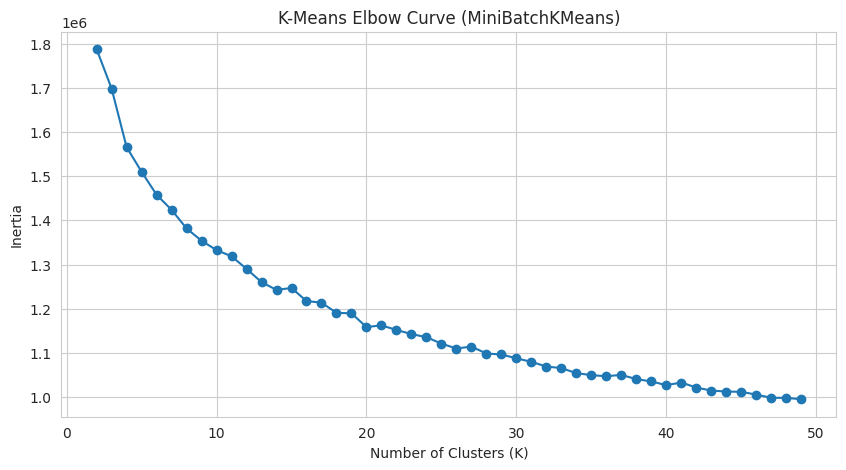

In [8]:
# Elbow method to find optimal K
print("Finding optimal number of clusters using elbow method...")

USE_MINIBATCH_KMEANS = True

# Choose clustering algorithm based on configuration
ClusteringClass = MiniBatchKMeans if USE_MINIBATCH_KMEANS else KMeans
print(f"Using: {ClusteringClass.__name__}")

inertias = []
K_range = range(2, 50)

for k in tqdm(K_range):
    if USE_MINIBATCH_KMEANS:
        kmeans = MiniBatchKMeans(
            n_clusters=k, 
            random_state=42, 
            batch_size=50000,
            n_init=10,  # Reduced for speed
            max_iter=100
        )
    else:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    kmeans.fit(filtered_features)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(K_range, inertias, marker='o')
ax.set_xlabel('Number of Clusters (K)')
ax.set_ylabel('Inertia')
ax.set_title(f'K-Means Elbow Curve ({ClusteringClass.__name__})')
ax.grid(True)
plt.show()

In [39]:
# Choose K and perform K-means clustering
optimal_k = 18  # Adjust based on elbow curve

print(f"Performing K-means clustering with K={optimal_k}...")
if USE_MINIBATCH_KMEANS:
    kmeans = MiniBatchKMeans(
        n_clusters=optimal_k, 
        random_state=42, 
        batch_size=50000,
        n_init=10,
        max_iter=100
    )
    print("Using MiniBatchKMeans (faster for large datasets)")
else:
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    print("Using standard KMeans")

kmeans_labels = kmeans.fit_predict(filtered_features)

print(f"\nK-means cluster distribution:")
unique, counts = np.unique(kmeans_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Cluster {label}: {count:,} Gaussians ({100*count/len(kmeans_labels):.1f}%)")

# Free memory
gc.collect()

Performing K-means clustering with K=18...
Using MiniBatchKMeans (faster for large datasets)

K-means cluster distribution:
  Cluster 0: 91,606 Gaussians (8.5%)
  Cluster 1: 55,977 Gaussians (5.2%)
  Cluster 2: 120,862 Gaussians (11.2%)
  Cluster 3: 92,988 Gaussians (8.6%)
  Cluster 4: 11,913 Gaussians (1.1%)
  Cluster 5: 98,258 Gaussians (9.1%)
  Cluster 6: 39,706 Gaussians (3.7%)
  Cluster 7: 74,482 Gaussians (6.9%)
  Cluster 8: 45,608 Gaussians (4.2%)
  Cluster 9: 41,838 Gaussians (3.9%)
  Cluster 10: 125,797 Gaussians (11.6%)
  Cluster 11: 24,919 Gaussians (2.3%)
  Cluster 12: 36,427 Gaussians (3.4%)
  Cluster 13: 17,546 Gaussians (1.6%)
  Cluster 14: 12,945 Gaussians (1.2%)
  Cluster 15: 15,421 Gaussians (1.4%)
  Cluster 16: 135,055 Gaussians (12.5%)
  Cluster 17: 39,668 Gaussians (3.7%)


13460

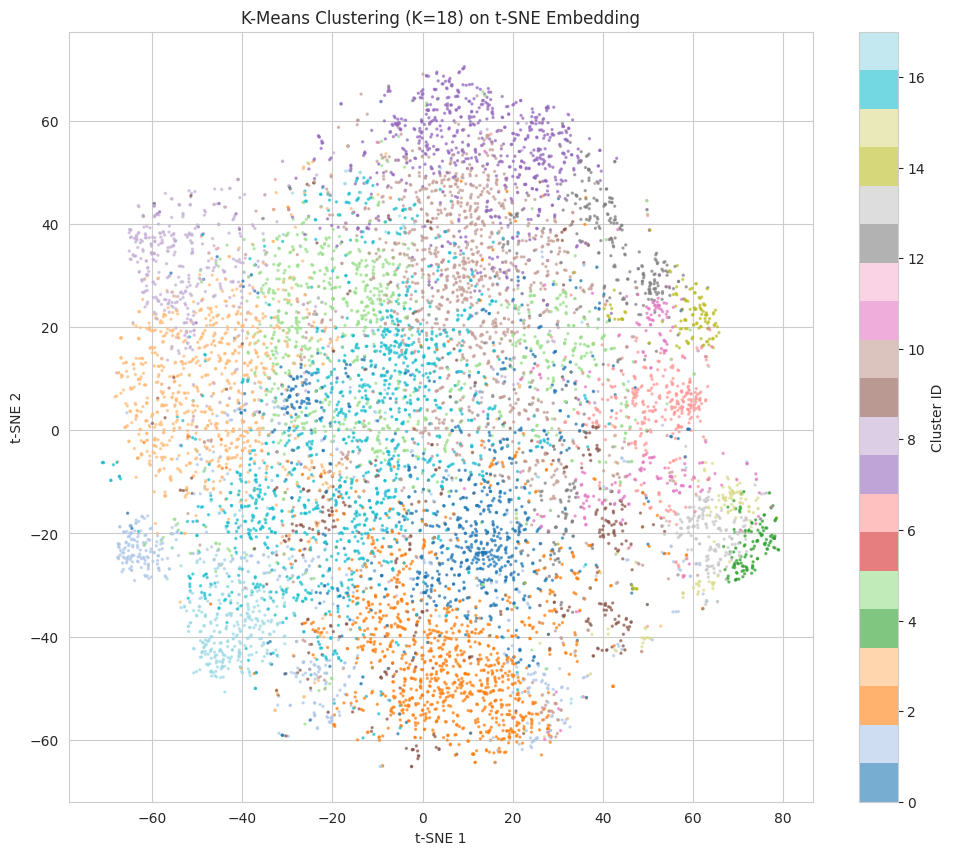

In [40]:
# Visualize K-means clusters on t-SNE embedding
fig, ax = plt.subplots(figsize=(12, 10))

scatter = ax.scatter(
    features_tsne[:, 0],
    features_tsne[:, 1],
    c=kmeans_labels[sample_idx],
    cmap='tab20',
    s=2,
    alpha=0.6
)
ax.set_title(f'K-Means Clustering (K={optimal_k}) on t-SNE Embedding')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
plt.colorbar(scatter, ax=ax, label='Cluster ID')
plt.show()

## Decode Feature Embeddings with CLIP

Use CLIP's text encoder to find semantic labels that best match each cluster

In [ ]:
# Initialize CLIP text encoder from the model
if hasattr(model, 'text_encoder') and model.text_encoder is not None:
    text_encoder = model.text_encoder
    print(f"Using model's text encoder: {type(text_encoder).__name__}")
else:
    # Load CLIP encoder if not available
    print("Loading CLIP text encoder...")
    text_encoder = BaseFeatureExtractor.get('samclip')(device=model.device)
    
text_encoder.eval()

In [ ]:
# Define candidate semantic labels to test
# Customize this list based on your scene content
candidate_labels = [
    # General objects
    "background", "foreground", "object", "sky", "ground", "floor", "wall", "ceiling",
    
    # Natural elements
    "tree", "plant", "leaves", "grass", "flowers", "rocks", "water", "dirt", "soil",
    
    # Animals (for birds/rats datasets)
    "bird", "feather", "wing", "beak", "feeder", "perch",
    "rat", "mouse", "rodent", "fur", "tail",
    
    # Common scene elements
    "wood", "metal", "plastic", "fabric", "glass",
    "container", "box", "platform", "structure",
    
    # Lighting and shadow
    "shadow", "bright area", "dark area", "highlight", "reflection"
]

print(f"Testing {len(candidate_labels)} semantic labels")

In [ ]:
def decode_cluster_to_labels(
    cluster_features: np.ndarray,
    text_encoder,
    candidate_labels: List[str],
    top_k: int = 5
) -> Dict[str, float]:
    """
    Decode a cluster's features to semantic labels using CLIP.
    
    Args:
        cluster_features: Feature embeddings for Gaussians in the cluster (N, D)
        text_encoder: CLIP text encoder
        candidate_labels: List of candidate semantic labels
        top_k: Number of top labels to return
    
    Returns:
        Dictionary mapping labels to similarity scores
    """
    # First, decode the features back to CLIP space using the model's decoder
    with torch.no_grad():
        # Convert to torch
        cluster_features_torch = torch.from_numpy(cluster_features).to(model.device)
        
        # Decode through the MLP to get CLIP features
        # This uses per_gaussian_forward which applies the decoder per-Gaussian
        decoded_dict = model.decoder.per_gaussian_forward(cluster_features_torch)
        
        # Get the main feature type (e.g., 'samclip')
        clip_features = decoded_dict[model.main_features_name]  # (N, C)
        
        # Average across all Gaussians in the cluster
        avg_clip_features = F.normalize(clip_features.mean(dim=0, keepdim=True), dim=-1)
        
        # Encode candidate text labels
        text_embeddings = text_encoder.encode_text(candidate_labels)  # (L, C)
        
        # Compute cosine similarities
        similarities = (avg_clip_features @ text_embeddings.T).squeeze(0)  # (L,)
        similarities = similarities.cpu().numpy()
    
    # Get top-k labels
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    
    results = {}
    for idx in top_indices:
        results[candidate_labels[idx]] = float(similarities[idx])
    
    return results

In [ ]:
# Decode K-means clusters
print("Decoding K-means clusters to semantic labels...\n")

kmeans_semantic_labels = {}

for cluster_id in range(optimal_k):
    # Get features for this cluster
    cluster_mask = kmeans_labels == cluster_id
    cluster_features = filtered_features[cluster_mask]
    
    # Decode to semantic labels
    top_labels = decode_cluster_to_labels(
        cluster_features,
        text_encoder,
        candidate_labels,
        top_k=5
    )
    
    kmeans_semantic_labels[cluster_id] = top_labels
    
    # Print results
    print(f"Cluster {cluster_id} ({cluster_mask.sum():,} Gaussians):")
    for label, score in top_labels.items():
        print(f"  {label}: {score:.3f}")
    print()

## Alternative: Use Open-Vocabulary Tools for CLIP Decoding

For more sophisticated decoding, you can use:

1. **CLIP Interrogator** - Generates natural language descriptions from CLIP embeddings
   ```python
   # Install: pip install clip-interrogator
   from clip_interrogator import Config, Interrogator
   
   ci = Interrogator(Config(clip_model_name="ViT-L-14/openai"))
   ```

2. **OpenAI CLIP with exhaustive search** - Test against larger vocabularies
   ```python
   # Use ImageNet labels, WordNet, or custom vocabularies
   from torchvision.datasets import ImageNet
   imagenet_labels = ImageNet.classes
   ```

3. **Concept bottleneck models** - Learn interpretable intermediate representations

4. **FALCON** - Retrieves concept compositions from CLIP
   - Paper: https://arxiv.org/abs/2302.10893
   - Better for compositional concepts like "red car" or "sitting bird"


## Visualize Clusters in 3D Space

Plot the Gaussian positions colored by cluster assignment using matplotlib and PyVista

In [ ]:
# 3D scatter plot of K-means clusters
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(111, projection='3d')
scatter1 = ax1.scatter(
    filtered_positions[:, 0],
    filtered_positions[:, 1],
    filtered_positions[:, 2],
    c=kmeans_labels,
    cmap='tab20',
    s=1,
    alpha=0.3
)
ax1.set_title(f'K-Means Clusters (K={optimal_k}) in 3D Space')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
plt.colorbar(scatter1, ax=ax1, label='Cluster ID')

plt.tight_layout()
plt.show()

### PyVista 3D Visualization

Use PyVista to create interactive 3D visualizations of the clusters, similar to the visualization notebook

In [11]:
from collab_splats.utils.visualization import MESH_KWARGS, VIZ_KWARGS
from collab_splats.utils.segmentation import get_n_different_colors

# Load the mesh transform
mesh_transform = splatter.load_mesh_transform()

# Now map the points to the mesh
points = np.asarray(filtered_positions)
points_homo = np.concatenate([points, np.ones((points.shape[0], 1))], axis=-1)
points_homo = mesh_transform["mesh_transform"] @ points_homo.T

# Move back out of homogenous coordinates
points = points_homo.T[..., :-1]

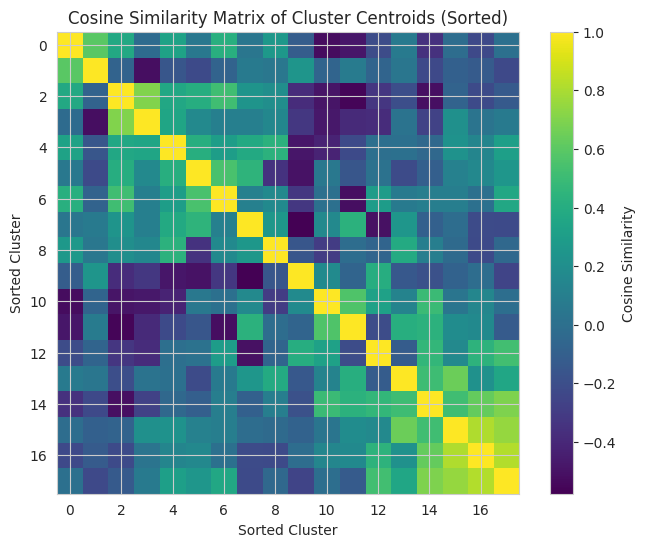

In [41]:
import colorsys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import linkage, leaves_list

# Compute cluster centroids
centroids = kmeans.cluster_centers_

# Compute cosine similarity matrix between centroids
similarity_matrix = cosine_similarity(centroids)

# Sort the similarity matrix so that similar clusters are grouped together
# Approach: Hierarchical clustering on the distance (1 - similarity)
distance_matrix = 1 - similarity_matrix
linkage_matrix = linkage(distance_matrix, method='average')
sorted_indices = leaves_list(linkage_matrix)

sorted_similarity_matrix = similarity_matrix[sorted_indices][:, sorted_indices]

# Plot the sorted similarity matrix
plt.figure(figsize=(8, 6))
im = plt.imshow(sorted_similarity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(im, label='Cosine Similarity')
plt.title('Cosine Similarity Matrix of Cluster Centroids (Sorted)')
plt.xlabel('Sorted Cluster')
plt.ylabel('Sorted Cluster')
plt.show()

# For good visual discretization, use distinct hues in HSV space mapped to RGB
n_clusters = optimal_k  # Should match KMeans.n_clusters

# Evenly space hues around the HSV circle for each cluster
hues = np.linspace(0, 1, n_clusters, endpoint=False)
saturation = 0.65
value = 0.95

cluster_colors = np.array([
    [int(c * 255) for c in colorsys.hsv_to_rgb(h, saturation, value)]
    for h in hues
], dtype=np.uint8)

# Assign cluster color to each point according to its label
point_colors = cluster_colors[kmeans_labels]

/opt/conda/envs/nerfstudio/lib/python3.10/site-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(


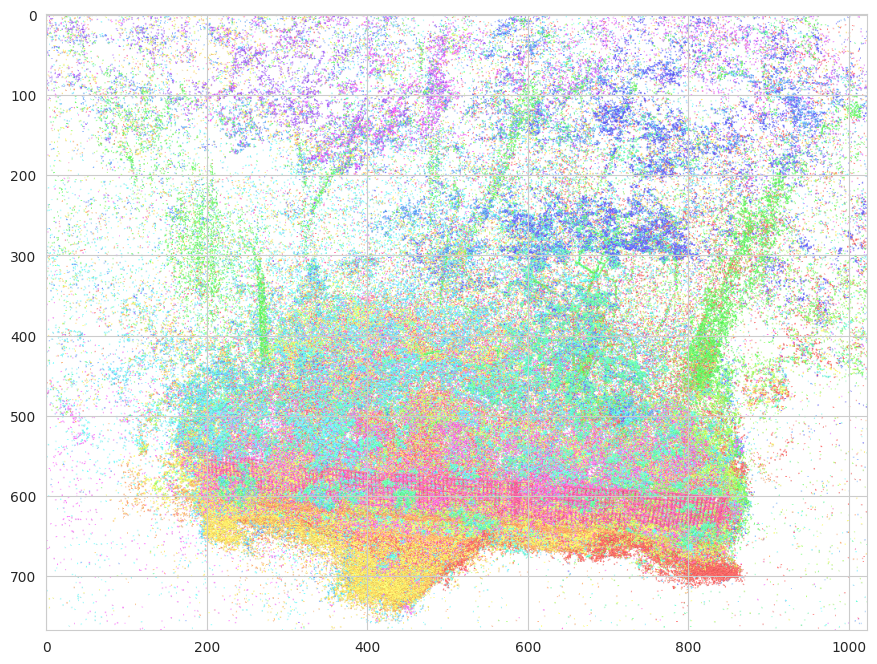

In [ ]:
# Start PyVista virtual framebuffer for visualization
pv.start_xvfb()

splat = pv.PolyData(points)

# colors = get_n_different_colors(optimal_k)
splat.point_data["RGB"] = point_colors #colors[kmeans_labels]

pcd_kwargs = MESH_KWARGS.copy()
pcd_kwargs.update(
    {
        "point_size": 2,
        "render_points_as_spheres": True,
        "ambient": 0.3,
        "diffuse": 0.8,
        "specular": 0.1,
    }
)

plotter = visualize_splat(
    mesh=splat,
    mesh_kwargs=pcd_kwargs,
    viz_kwargs=VIZ_KWARGS,
)

img = plotter.screenshot()
plt.imshow(img)

### Visualize Individual Clusters

Select and visualize specific clusters to understand their spatial distribution

In [ ]:
# Select a specific cluster to visualize (e.g., cluster 0)
cluster_to_visualize = 0

# Get the semantic label for this cluster
if cluster_to_visualize in kmeans_semantic_labels:
    top_label = list(kmeans_semantic_labels[cluster_to_visualize].keys())[0]
    top_score = list(kmeans_semantic_labels[cluster_to_visualize].values())[0]
    cluster_description = f"Cluster {cluster_to_visualize}: {top_label} (score: {top_score:.3f})"
else:
    cluster_description = f"Cluster {cluster_to_visualize}"

# Create a mask for the selected cluster
cluster_mask = kmeans_labels == cluster_to_visualize
cluster_points = filtered_positions[cluster_mask]

# Create PyVista point cloud for the selected cluster
pv_cluster = pv.PolyData(cluster_points)

print(f"{cluster_description}")
print(f"Number of points in cluster: {cluster_points.shape[0]:,}")

# Visualize just this cluster
plotter = pv.Plotter()
plotter.add_points(
    pv_cluster,
    color="red",
    point_size=6,
    render_points_as_spheres=True,
)
plotter.add_text(cluster_description, font_size=12)
plotter.show_grid()
plotter.show()

### Visualize Multiple Clusters with Context

Show selected clusters highlighted against the full point cloud

In [ ]:
# Select multiple clusters to highlight
clusters_to_highlight = [0, 1, 2]  # Modify to visualize different clusters

# Create a visualization showing selected clusters against full point cloud
plotter = pv.Plotter()

# Add all points in gray (background)
pv_background = pv.PolyData(filtered_positions)
plotter.add_points(
    pv_background,
    color="lightgray",
    point_size=2,
    opacity=0.3,
    render_points_as_spheres=False,
)

# Add highlighted clusters with different colors
colors = ["red", "green", "blue", "yellow", "magenta", "cyan"]
for idx, cluster_id in enumerate(clusters_to_highlight):
    cluster_mask = kmeans_labels == cluster_id
    cluster_points = filtered_positions[cluster_mask]
    pv_cluster = pv.PolyData(cluster_points)
    
    # Get semantic label
    if cluster_id in kmeans_semantic_labels:
        top_label = list(kmeans_semantic_labels[cluster_id].keys())[0]
        label_text = f"Cluster {cluster_id}: {top_label}"
    else:
        label_text = f"Cluster {cluster_id}"
    
    plotter.add_points(
        pv_cluster,
        color=colors[idx % len(colors)],
        point_size=6,
        render_points_as_spheres=True,
        label=label_text,
    )

plotter.add_legend()
plotter.add_text("Selected Clusters Highlighted", font_size=12)
plotter.show_grid()
plotter.show()

## Save Results

Save cluster assignments and semantic labels for further analysis

In [ ]:
# Save clustering results
output_dir = base_dir / "clustering_analysis"
output_dir.mkdir(exist_ok=True)

results = {
    'kmeans': {
        'labels': kmeans_labels,
        'n_clusters': optimal_k,
        'semantic_labels': kmeans_semantic_labels,
    },
    'metadata': {
        'opacity_threshold': OPACITY_THRESHOLD,
        'n_total_gaussians': model.means.shape[0],
        'n_valid_gaussians': len(filtered_features),
        'feature_dim': filtered_features.shape[1],
    }
}

# Save as pickle
with open(output_dir / 'clustering_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print(f"Results saved to: {output_dir / 'clustering_results.pkl'}")

# Also save a human-readable summary
with open(output_dir / 'semantic_labels.txt', 'w') as f:
    f.write("K-MEANS CLUSTERING RESULTS\n")
    f.write("=" * 70 + "\n\n")
    
    f.write(f"Total Gaussians: {model.means.shape[0]:,}\n")
    f.write(f"Valid Gaussians (opacity > {OPACITY_THRESHOLD}): {len(filtered_features):,}\n")
    f.write(f"Number of clusters: {optimal_k}\n\n")
    
    for cluster_id, labels in kmeans_semantic_labels.items():
        cluster_size = (kmeans_labels == cluster_id).sum()
        f.write(f"Cluster {cluster_id} ({cluster_size:,} Gaussians, {100*cluster_size/len(kmeans_labels):.1f}%):\n")
        for label, score in labels.items():
            f.write(f"  {label}: {score:.3f}\n")
        f.write("\n")

print(f"Semantic labels saved to: {output_dir / 'semantic_labels.txt'}")

## Summary and Next Steps

This notebook demonstrated:
1. Loading a trained rade-features model
2. Extracting feature embeddings from Gaussians
3. **Performance optimization strategies for large datasets**
4. K-means clustering to discover semantic categories
5. Decoding CLIP embeddings to semantic labels
6. **Visualizing clusters in 3D using PyVista**

### Performance Optimization Strategies:

For datasets with **>100k Gaussians**, use these strategies to speed up clustering:

1. **Increase Opacity Threshold** (0.3-0.7)
   - Filters out low-quality/transparent Gaussians
   - Can reduce dataset by 50-80%
   - **Speed gain: 2-10x**

2. **Spatial Filtering**
   - Focus on a region of interest
   - Useful for large scenes
   - **Speed gain: 2-5x** (depending on region)

3. **Random Subsampling** (50k-200k points)
   - Randomly sample after filtering
   - Still captures overall structure
   - **Speed gain: 5-20x** for very large datasets

4. **Use MiniBatch K-Means**
   - Processes data in batches
   - Linear memory complexity
   - **Speed gain: 3-10x** vs standard K-Means

5. **Reduce PCA Dimensions** (20-30 components)
   - Fewer dimensions = faster clustering
   - Usually retains 90%+ variance
   - **Speed gain: 1.5-3x**

### K-Means Clustering:

**Advantages:**
- ✓ Fast and scalable (MiniBatch is fastest)
- ✓ Produces balanced clusters
- ✓ Works well with large datasets
- ✓ Simple to interpret and visualize

**Limitations:**
- ✗ Requires pre-specifying K (use elbow method)
- ✗ Assumes spherical clusters
- ✗ Sensitive to initialization (use multiple runs)

### Suggested Next Steps:

1. **Refine clustering**: Adjust K based on elbow curve and semantic coherence
2. **Expand vocabulary**: Add more domain-specific labels to `candidate_labels`
3. **Map to mesh**: Project cluster labels onto a mesh reconstruction
4. **Hierarchical clustering**: Use a two-stage approach (coarse → fine)
5. **Query-based segmentation**: Use semantic labels to query specific objects
6. **Save cluster meshes**: Export individual clusters as separate PLY files for visualization

### PyVista Visualization Tips:

- Use `point_size` and `render_points_as_spheres=True` for better point visibility
- Use categorical colormaps (`tab20`, `tab10`) for discrete cluster IDs
- Highlight specific clusters by rendering them on top of a gray background
- Save screenshots with `plotter.screenshot('filename.png')`
- Export to interactive HTML with `plotter.export_html('filename.html')`